# Pricing PL Term Structure

In [ ]:
import pandas as pd
from pyacm import NominalACM
import matplotlib.pyplot as plt
from itertools import product
from matplotlib.ticker import StrMethodFormatter


FIGSIZE = (16, 9)
TITLE_FONT_SIZE = 24
SUBTITLE_FONT_SIZE = 14

## Zero-coupon yields

In [30]:
data = pd.read_parquet("data/nss_curve.parquet")
data = data.drop(columns=["beta0", "beta1", "beta2", "beta3", "tau1", "tau2"])
# data = data.resample("ME").last()
data.columns = [int(col) for col in data.columns]

data.loc[::200, [12, 60, 120, 180]].style.format("{:.2%}").format_index("{:%Y-%m-%d}")

,12,60,120,180
Date,,,,
2011-01-03,4.19%,5.34%,5.94%,6.16%
2011-10-18,4.39%,5.12%,5.65%,5.86%
2012-08-06,4.15%,4.30%,4.32%,4.33%
2013-05-28,2.48%,2.88%,3.44%,3.74%
2014-03-18,2.75%,3.63%,4.32%,4.62%
2015-01-09,1.73%,1.90%,1.92%,1.93%
2015-10-23,1.56%,2.12%,2.65%,2.89%
2016-08-22,1.43%,2.09%,2.71%,3.01%
2017-06-08,1.47%,2.62%,3.16%,3.37%


In [3]:
acm = NominalACM(
    curve=data.resample("ME").last(),
    n_factors=5,
)

c:\Users\alans\REPOS\twitter_bot\.venv\Lib\site-packages\pyacm\acm.py:155: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.curve_monthly = curve.resample('M').mean()


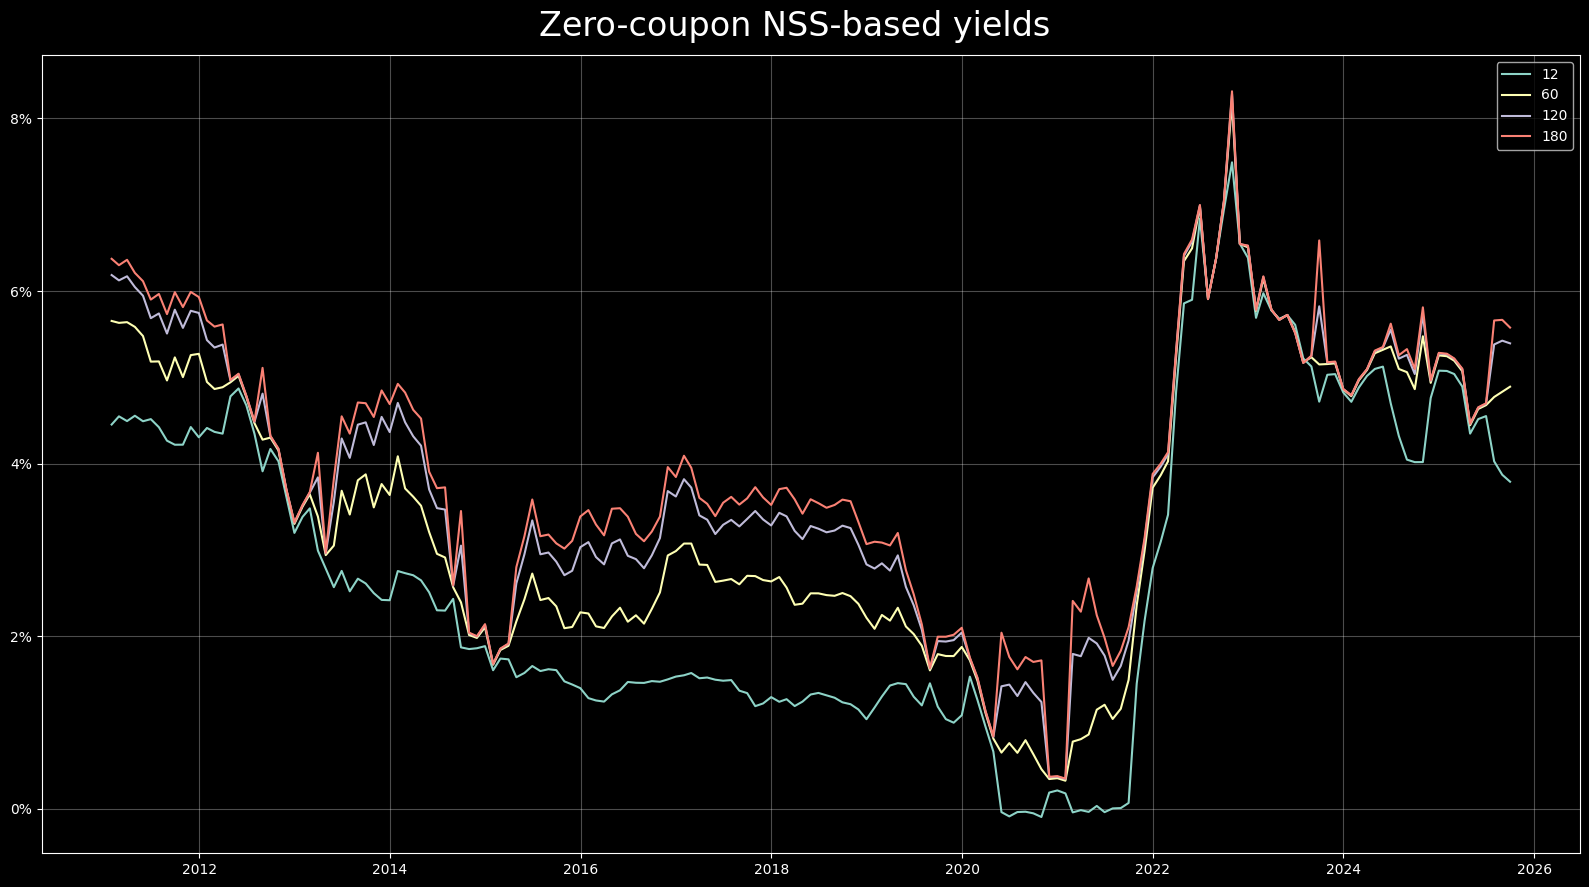

In [4]:
fig, ax = plt.subplots(figsize=FIGSIZE)

fig.gca().yaxis.set_major_formatter("{x:.0%}")
fig.suptitle("Zero-coupon NSS-based yields", fontsize=TITLE_FONT_SIZE)

for i in [12, 60, 120, 180]:
    ax.plot(acm.curve[i], label=i)
ax.legend()
ax.grid(alpha=0.3)


plt.tight_layout()
plt.show()

## Observed vs Risk-Neutral

Model generuje szacunki neutralnych pod względem ryzyka stóp procentowych, które teoretycznie stanowią jedynie element oczekiwania krzywej, usuwając premię terminową z obserwowanej stopy.

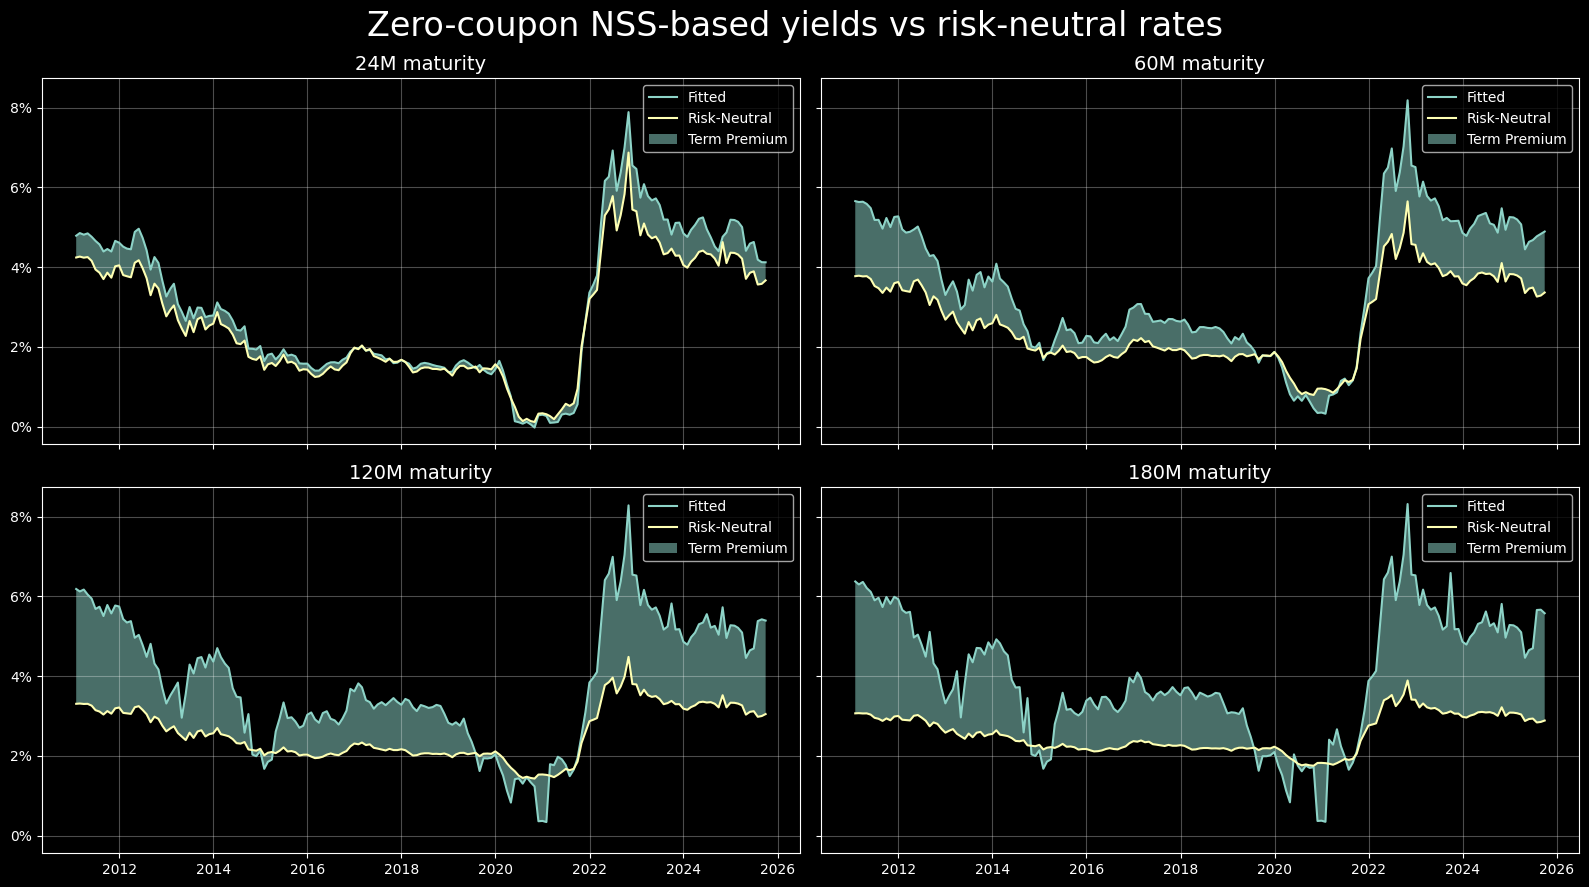

In [ ]:
fig, ax = plt.subplots(2, 2, sharex="all", sharey="all", figsize=FIGSIZE)

fig.gca().yaxis.set_major_formatter("{x:.0%}")
fig.suptitle("Zero-coupon NSS-based yields vs risk-neutral rates", fontsize=TITLE_FONT_SIZE)

for curve, i in zip((24, 60, 120, 180), product((0, 1), (0, 1))):
    ax[i].plot(acm.curve[curve], label="Fitted")
    ax[i].plot(acm.rny[curve], label="Risk-Neutral")

    ax[i].fill_between(
        acm.curve.index,
        acm.curve[curve],
        acm.rny[curve],
        facecolor="#93ddd15a",
        alpha=0.5,
        label="Term Premium",
        interpolate=True,
    )

    ax[i].set_title(f"{curve}M maturity", fontsize=SUBTITLE_FONT_SIZE)
    ax[i].legend()
    ax[i].grid(alpha=0.3)


plt.tight_layout()
plt.show()

## Term Premiums

Są różnicą między obserwowanymi stopami a stopą neutralną pod względem ryzyka.

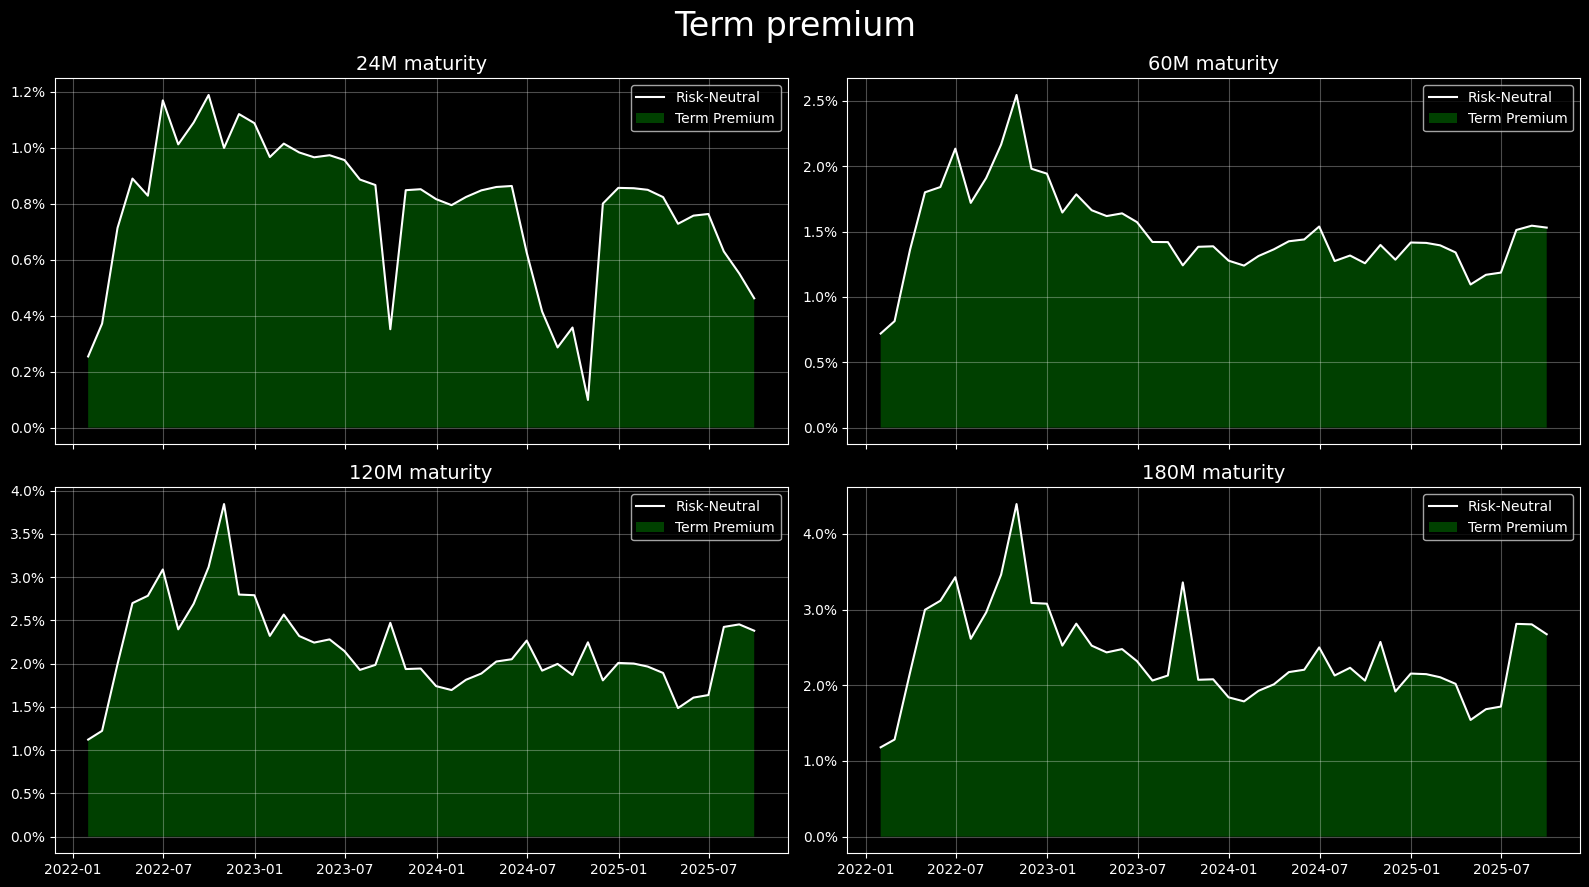

In [31]:
fig, ax = plt.subplots(2, 2, sharex="all", figsize=FIGSIZE)

fig.suptitle("Term premium", fontsize=TITLE_FONT_SIZE)

for curve, i in zip((24, 60, 120, 180), product((0, 1), (0, 1))):
    tp = acm.tp.loc["2022-01-01":, curve]
    ax[i].plot(tp, label="Risk-Neutral", color="white")
    ax[i].fill_between(
        tp.index, tp, 0, where=tp > 0, facecolor="green", alpha=0.5, label="Term Premium", interpolate=True
    )
    ax[i].fill_between(tp.index, tp, 0, where=tp < 0, facecolor="red", alpha=0.5, interpolate=True)

    ax[i].set_title(f"{curve}M maturity", fontsize=SUBTITLE_FONT_SIZE)
    ax[i].legend()
    ax[i].grid(alpha=0.3)
    ax[i].get_yaxis().set_major_formatter("{x:.1%}")


plt.tight_layout()
plt.show()


Artykuł wyraźnie pokazuje różnicę między premią terminową a oczekiwanymi stopami zwrotu.

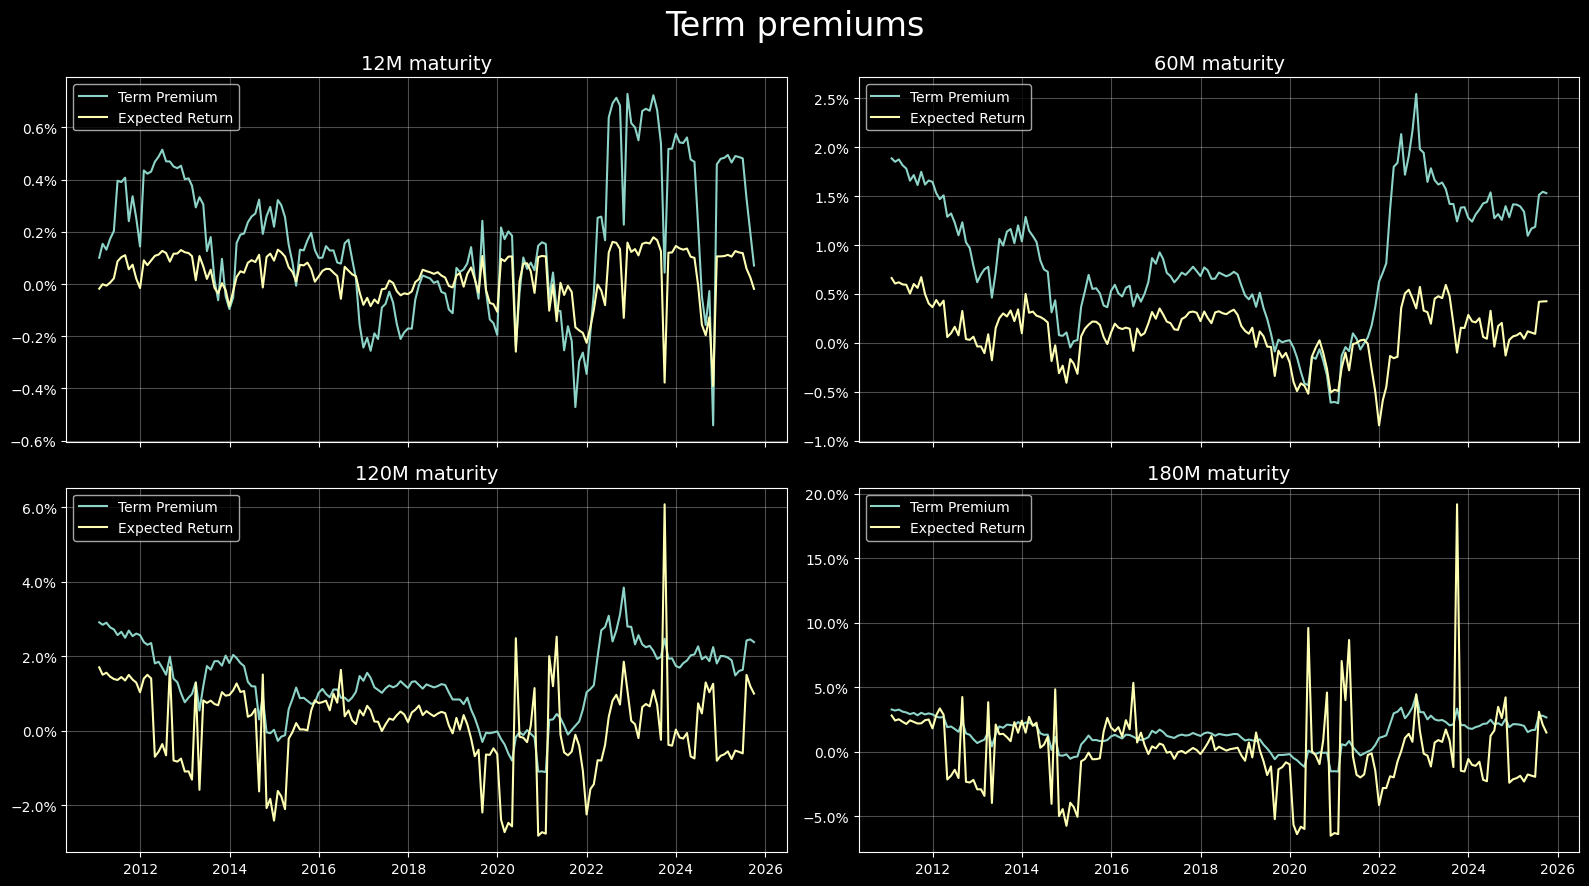

In [7]:
fig, ax = plt.subplots(2, 2, sharex="all", figsize=FIGSIZE)

fig.suptitle("Term premiums", fontsize=TITLE_FONT_SIZE)

for curve, i in zip((12, 60, 120, 180), product((0, 1), (0, 1))):
    ax[i].plot(acm.tp[curve], label="Term Premium")
    ax[i].plot(acm.er_hist[curve], label="Expected Return")

    ax[i].set_title(f"{curve}M maturity", fontsize=SUBTITLE_FONT_SIZE)
    ax[i].legend()
    ax[i].grid(alpha=0.3)

    ax[i].get_yaxis().set_major_formatter("{x:.1%}")


plt.tight_layout()
plt.show()


## Forward Curves

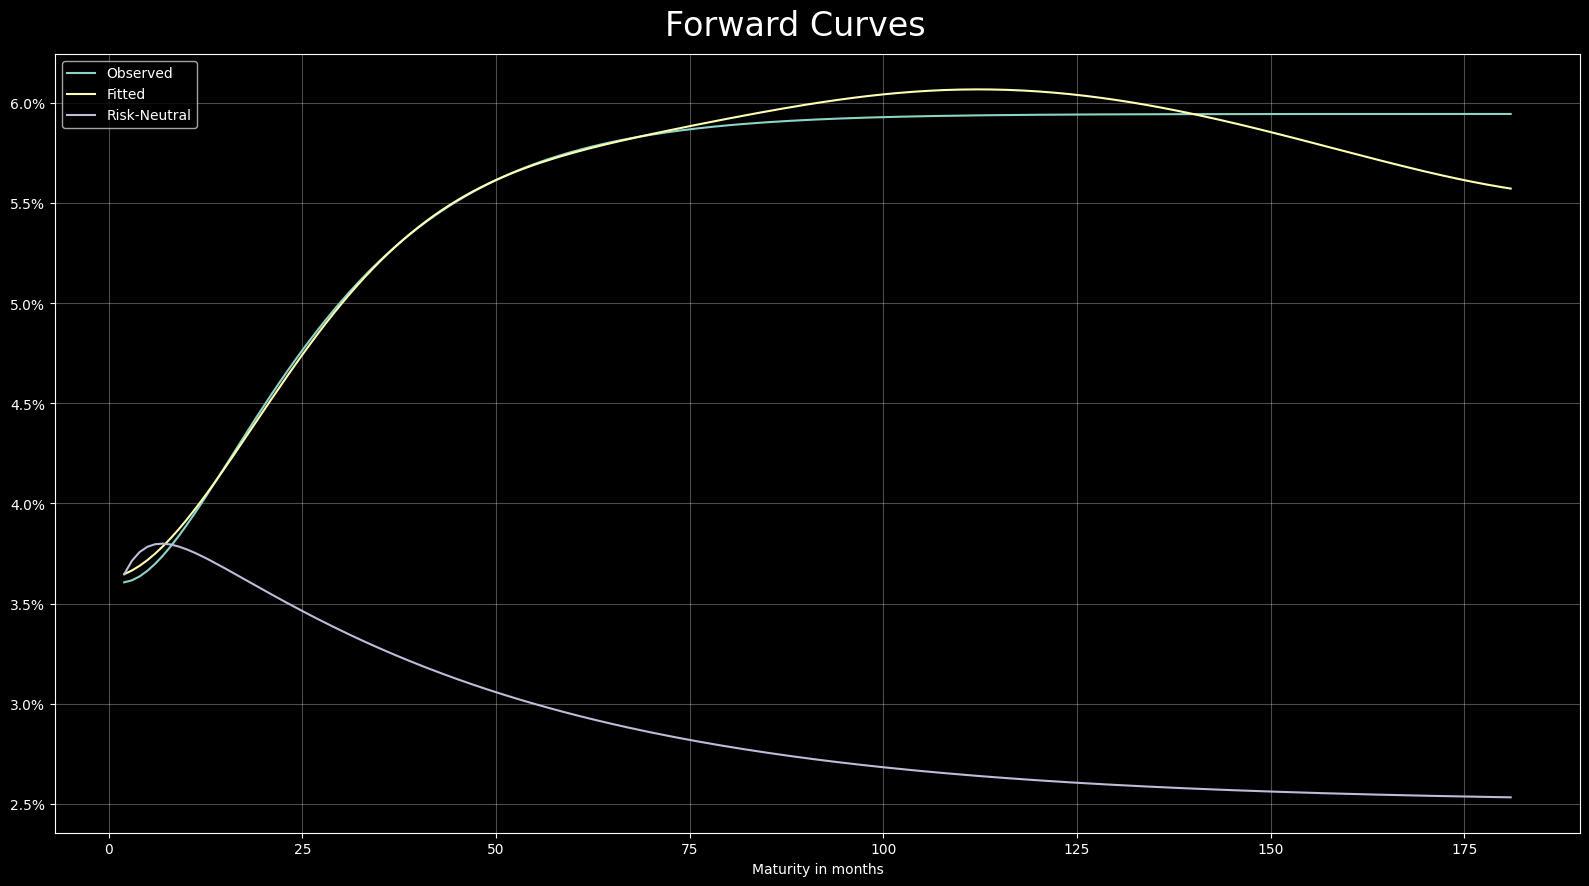

In [8]:
fig, ax = plt.subplots(figsize=FIGSIZE)

fig.suptitle("Forward Curves", fontsize=TITLE_FONT_SIZE)

fwd_curve = acm.fwd_curve(data.index[-1])
ax.plot(fwd_curve.index + 1, fwd_curve, label=fwd_curve.columns)
ax.legend()
ax.grid(alpha=0.3)
ax.set_xlabel("Maturity in months")
ax.get_yaxis().set_major_formatter("{x:.1%}")

plt.tight_layout()
plt.show()